## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Tarea 2: Algoritmos de entrenamiento y aproximación de esperanzas condicionales**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

**Nombres integrantes: Sebastiàn P. Pincheira & Miguel Escobar**



**Instrucciones:**

- **Fecha de entrega:** **31 de mayo de 2024, a las 23:59.**

- **Importante:** Si trabaja desde el link de Google Colab debe hacer un copia en su Drive antes de trabajar, de lo contrario se podrían no guardar sus códigos.

- Debe entregar un Jupyter Notebook (archivo .ipynb) con sus código en Python. Le pueden ser de mucha utilidad los códigos vistos en la actividad práctica.

- Sus códigos deben estar comentados y ordenados. Además, en formato texto debe colocar todas sus conclusiones y resultados pedidos que deban ser redactados.

- En todos los ejercicios se le pide hacer al menos un gráfico. Los gráficos que realicen deben ser claros, con títulos y nombres en los ejes, junto con leyendas si es que corresponde.

#### **Ejercicio 1: Algoritmo Adam**

En el presente [artículo](https://arxiv.org/abs/1412.6980) se introduce el algoritmo de optimización estocástica Adam (por Adaptative Moment Estimation), el objetivo de este ejercicio es implementar dicho algoritmo y utilizarlo para entrenar redes neuronales, para ello se explorarán todos los detalles de implementación de una red neuronal, con ciertas simplificaciones.

Utilizaremos Adam para entrenar una red neuronal de 1 capa oculta de $\mathbb{R}$ en $\mathbb{R}$, de ancho $batch_size$, con su realización dada por

$$ \Phi_\theta (x) = W_2 \cdot \sigma (W_1 \cdot x + b_1) + b_2 $$

Consideraremos $\sigma(x) = \text{tanh}(x)$ y $\theta = (W_1, b_1, W_2, b_2)$, $W_1 \in \mathbb{R}^{batch_size \times 1}$, $b_1 \in \mathbb{R}^{batch_size}$, $W_2 \in \mathbb{R}^{1 \times batch_size}$, $b_2 \in \mathbb{R}$. En este caso codificaremos, los parámetros del sistema en un vector de $\mathbb{R}^{3N + 1}$ dado por

$$ \theta = (W_1, b_1, W_2, b_2)^T $$

Esto no es lo que hacen las librerías de aprendizaje profundo en la realidad, pero en este caso permite simplificar mucho los manejos de estructuras de datos utilizadas.

Para lo que sigue utilizaremos la librería ``autograd`` (instalada ya en Google Colab) que facilitará implementar la diferenciación automática (utilizada en las librerías más importantes de *deep learning*) para calcular facilmente el gradiente de la función de pérdida. Esta librería sobrescribe la librería ``numpy`` por lo que ahora utilizaremos esa librería con el sobrenombre ``np`` como si fuese la librería original.

In [5]:
# Numpy de autograd
import autograd.numpy as np

# Función de gradiente mediante diferenciación automática
from autograd import grad

# Para graficar
import matplotlib.pyplot as plt

In [6]:
# Librerias agregadas por los alumnos

# Permite utilizar isinstance y tuple en autograd
from autograd.builtins import isinstance, tuple

# Módulo para anotar funciones
from typing import Union

# Para hacer DataFrames
import pandas as pd

# Animaciones
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import Video, display

# Manejo de archivos
import os

# Fijamos la semilla de numpy
np.random.seed(115)

# Importamos PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Fijamos la semilla de PyTorch
torch.manual_seed(115)

# Importamos la librería para crear barras de carga
try:
    from tqdm import tqdm
    tqdm_is_available = True
except:
    tqdm_is_available = False
print("tqdm disponible:", tqdm_is_available)

# Notas:
# Documentación de autograd: https://github.com/HIPS/autograd

tqdm disponible: True


Buscaremos ajustar la red neuronal a datos *sampleados* desde una función $\text{cos}(x)$ con cierto ruido gaussiano. Generemos los datos antes de empezar el ejercicio.

In [7]:
# Función a aproximar
def f_true(x):
    return np.cos(x)

In [8]:
xdim = 1  # Dimensión de input
Ndata = 20  # Cantidad de datos a samplear
ydim = 1  # Dimensión de output

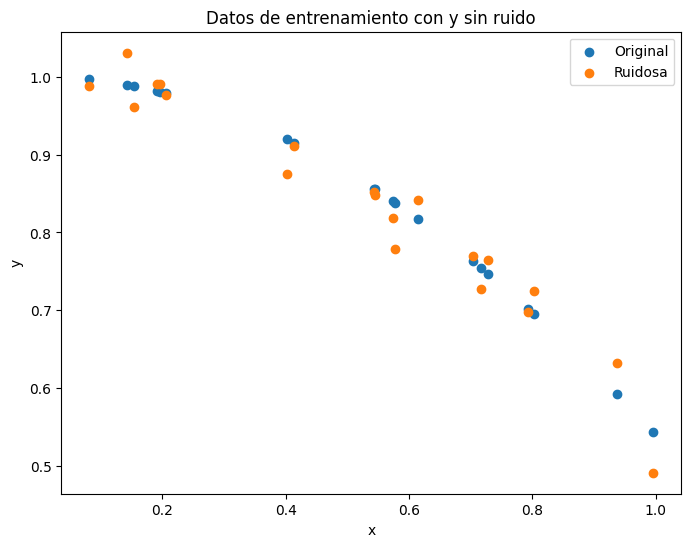

In [9]:
# Datos aleatorios
x_train = np.random.random((xdim, Ndata))

# Sampleo de datos
desv = 3e-2
y_train = f_true(x_train) + desv * np.random.randn(*x_train.shape)

plt.figure(figsize=(8, 6))
plt.scatter(x_train.flatten(), f_true(x_train).flatten(), label="Original")
plt.scatter(x_train.flatten(), y_train.flatten(), label="Ruidosa")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos de entrenamiento con y sin ruido")
plt.legend()
plt.show()

#### **Ejercicio 1.1: Creación de una red neuronal de 1 capa oculta**

Cree una función en Python ``net(params, x)`` que dados los parámetros codificados en un arreglo de ``numpy`` tal como se mostró arriba y un conjunto de datos $x \in \mathbb{R}^{1 \times N_{data}}$ calcule el output de la red. Pruebe su función con parámetros inicializados aleatoriamente desde una uniforme estándar y el arreglo ``x_train`` creado antes.

##### **Solución Ejercicio 1.1.**

Procedemos con la creación de la función `net` donde agregamos, además, un parámetro `sigma`, correspondiente a la función de activación, el cual predefinimos como `np.tanh`.

In [10]:
def net(params: np.array, x: np.array, sigma: callable = np.tanh) -> np.array:
    """
    Realisación de la red neuronal a una capa oculta, de ancho batch_size=(params.shape[0] - 1)/3, con dimensión de entrada y salida 1.

    En la capa de entrada, se aplica la función de activación tangente hiperbólica compuesta con la función afín
    Wa*x + ba, donde Wa son los primeros batch_size parámetros de params y ba los siguientes batch_size.
    De la segunda capa a la salida, se aplica la función afín Wb*x + bb (sin activación), donde Wb son los siguientes batch_size parámetros
    de params, después de haber asignado Wa y ba, y bb es el último parámetro.

    Se aplica esta red a cada dato de x.

    Args:
        params (np.array): Parámetros de la red neuronal.
        x (np.array): Datos de entrada de la red neuronal.
        sigma (callable): Función de activación. (Defaults: np.tanh)

    Returns:
        np.array: Datos de salida de la red neuronal.

    Raises:
        AssertionError: Si params no es un np.array.
        AssertionError: Si x no es un np.array.
        AssertionError: Si el número de parámetros no es correcto.
        AssertionError: Si la dimensión de x no es correcta.
    """

    assert isinstance(params, np.ndarray), "params debe ser un np.array."
    assert isinstance(x, np.ndarray), "x debe ser un np.array."
    assert params.shape[0] % 3 == 1, "El número de parámetros no es correcto."
    assert x.ndim == 1 or (
        x.ndim == 2 and 1 in x.shape
    ), "La dimensión de x no es correcta."

    shape = x.shape
    x = np.squeeze(x)
    params = np.squeeze(params)

    batch_size = int((params.shape[0] - 1) / 3)
    Wa = params[:batch_size]
    ba = params[batch_size : 2 * batch_size]
    Wb = params[2 * batch_size : 3 * batch_size]
    bb = params[3 * batch_size]

    def single_data_case(x: float) -> float:
        x = sigma(Wa * x + ba)
        x = Wb @ x + bb
        return x

    y = np.array([single_data_case(xi) for xi in x]).reshape(shape)

    return y

Basándonos en la tarea anterior, trabajaremos con una red de ancho 100, el mayor ancho experimentado en la Tarea 1. Evaluamos la función con parámetros aleatorios en el conjunto de datos `x_train`.

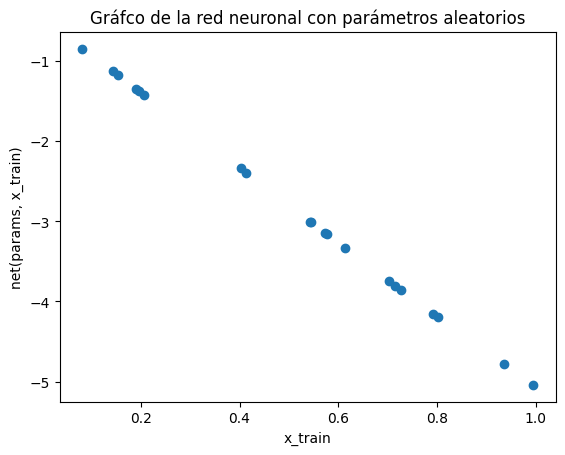

In [11]:
ancho = 100  # Ancho de la red neuronal

# Creamos un array de parámetros aleatorios mediante una uniforme standard
params = np.random.uniform(-1, 1, size=(3 * ancho + 1))

y = net(params, x_train)

# Creamos el plot
plt.scatter(x_train, y)

# Agregamos labels
plt.xlabel("x_train")
plt.ylabel("net(params, x_train)")
plt.title("Gráfco de la red neuronal con parámetros aleatorios")

# Mostramos el plot
plt.show()

#### **Ejercicio 1.2: Creación de la función de pérdida por *batches***

La naturaleza estocástica del algoritmo proviene de que no se le entregan todos los datos de entrenamiento, sino que una muestra diferente en cada iteración de entrenamiento, dichas muestras las denotaremos *batches*. Implemente una función en Python ``loss(params)`` que dados unos parámetros ``params`` $\theta$ haga lo siguiente:

* Obtenga un subarreglo de tamaño $(1, N_{batches})$ de ``x_train`` de manera aleatoria y sin sustitución, digamos ``x_batch``.
* Obtenga el ``y_batch`` correspondiente.
* Calcule la pérdida cuadrática en este *batch*:

$$ L(\theta) = \frac{1}{N_{batch}}\sum_{i=1}^{N_{batch}} (y_i - \Phi_\theta (x_i))^2 $$

##### **Solución Ejercicio 1.2.**

Creamos la función `loss` solicitada donde, además, se le definen los argumentos `x`, `y` y `batch_size` correspondiendo al conjunto de datos, los valores asociados a estos datos y el tamaño del minibatch que se quiere usar para calcular la pérdida (respectivamente). Predefinimos los valores de `x` e `y` como `x_train` e `y_train` pues, en adelante, es ahí donde nos interesa calcular el error. Además, predefinimos `batch_size` como `Ndata`, que es el caso en el que el minibatch es el conjunto completo.

In [12]:
def loss(
    params: np.array,
    x: np.array = x_train,
    y: np.array = y_train,
    batch_size: int = Ndata,
) -> float:
    """
    Función que toma un np.array de parámetros para la red neuronal, y un np.array de datos x e y, y calcula el error cuadrático medio
    de la red neuronal con los datos x e y, utilizando un batch de tamaño batch_size.

    Args:
        params (np.array): Parámetros de la red neuronal.
        x (np.array, optional): Datos de entrada de la red neuronal. Defaults to x_train.
        y (np.array, optional): Datos de salida de la red neuronal. Defaults to y_train.
        batch_size (int, optional): Tamaño del batch. Defaults to Nbatch.

    returns:
        float: Error cuadrático medio de la red neuronal con los datos x e y.

    Raises:
        AssertionError: Si params no es un np.array.
        AssertionError: Si x no es un np.array.
        AssertionError: Si y no es un np.array.
        AssertionError: Si batch_size no es un entero.
        AssertionError: Si el número de parámetros no es correcto.
        AssertionError: Si la dimensión de x no es correcta.
        AssertionError: Si las dimensiones de x e y no son compatibles.
        AssertionError: Si el tamaño del batch es muy grande.
    """

    assert isinstance(params, np.ndarray), "params debe ser un np.array."
    assert isinstance(x, np.ndarray), "x debe ser un np.array."
    assert isinstance(y, np.ndarray), "y debe ser un np.array."
    assert isinstance(batch_size, int), "batch_size debe ser un entero."

    assert params.shape[0] % 3 == 1, "El número de parámetros no es correcto."
    assert x.ndim == 1 or (
        x.ndim == 2 and 1 in x.shape
    ), "La dimensión de x no es correcta."
    assert x.shape == y.shape, "Las dimensiones de x e y no son compatibles."
    assert batch_size <= np.squeeze(x).shape[0], "El tamaño del batch es muy grande."

    x = np.squeeze(x)
    y = np.squeeze(y)

    # Elegimos un batch aleatorio con probabilidad uniforme sobre x, sin substitución
    indices = np.random.choice(len(x), size=batch_size, replace=False)
    x_batch = x[indices]

    # Obtenemos el y_batch correspondiente
    y_batch = net(params, x_batch)

    # Calculamos la perdida en el batch
    MSE = np.mean((y[indices] - y_batch) ** 2)

    return MSE

Como ejemplo, calculamos el error inicial de nuestra red.

In [13]:
error_inicial = loss(params)

print("El error inicial de la red es ", error_inicial)

El error inicial de la red es  14.952665636898379


#### **Ejercicio 1.3: Cálculo del gradiente vía autodiferenciación y comparación con diferencias finitas**

Con la función ``grad`` de ``autograd`` calcule el gradiente de la función de pérdida antes creada, con tamaño de *batch* igual a ``Ndata``, es decir, la función de pérdida se vuelve determinista en este caso (ya que le pasamos todos los datos al tomar los batches sin sustitución. Compare en norma este gradiente con el cálculado mediante por diferencias finitas centradas

$$ \frac{\partial L}{ \partial \theta_j} (\theta) \approx \frac{L(\theta + \varepsilon e_j) - L(\theta - \varepsilon e_j)}{2 \varepsilon} $$

Para $\varepsilon \in \{ 10, 1, 0.1, 0.01 \}$, evaluado los gradientes en los mismo parámetros utilizados en la parte anterior.

##### **Solución Ejercicio 1.3.**

Para esta sección, usaremos un batch size igual a la cantidad de datos de entrenamiento, es decir, estos resultados son de carácter determinista en cuanto a la función de error.

Calculamos el gradiente de `loss` mediante diferencias finitas.

In [14]:
def finite_diff_grad_loss(params: np.array, eps: Union[int, float] = 1e-2) -> np.array:
    """
    Función que toma un np.array de parámetros para la red neuronal, y calcula el gradiente de la función de perdida
    con respecto a los parámetros mediante diferencias finitas.

    Args:
        params (np.array): Parámetros de la red neuronal.
        eps (float, optional): Tamaño del paso para las diferencias finitas. Defaults to 1e-2.

    Returns:
        np.array: Gradiente de la función de perdida con respecto a los parámetros evaluada en params.

    Raises:
        AssertionError: Si params no es un np.array.
        AssertionError: Si eps no es un flotante.
    """

    assert isinstance(params, np.ndarray), "params debe ser un np.array."
    assert isinstance(eps, (int, float)), "eps debe ser un flotante."

    grad = np.zeros(params.shape)

    for i in range(len(params)):
        params[i] += eps
        loss_plus = loss(params)
        params[i] -= 2 * eps
        loss_minus = loss(params)
        params[i] += eps
        grad[i] = (loss_plus - loss_minus) / (2 * eps)

    return grad

Evaluamos el gradiente de la función `loss` mediante diferencias finitas para los valores de $\varepsilon$ solicitados. El gradiente será evaluado en el punto `params`, elegido arbitrariamente con anterioridad.

In [15]:
eps = [10, 1, 0.1, 0.01]

print(
    f"Valores del gradiente de la loss function mediante diferencias finitas para eps en {eps}:"
)
print()
finite_gradients = []
for e in eps:
    print(f"eps = {e}:")
    gradient = (e, finite_diff_grad_loss(params, e))
    finite_gradients.append(gradient)
    print(gradient[1])
    print()

Valores del gradiente de la loss function mediante diferencias finitas para eps en [10, 1, 0.1, 0.01]:

eps = 10:
[ 0.8008283   0.25818269 -0.65638094  0.12591751  0.23420846 -0.20324614
  0.15275711  0.38221993 -0.14070376 -0.1482437  -0.64970102 -0.66419399
 -0.61114242  0.23500309 -0.64133686 -0.41573959 -0.05829669 -0.07691096
  0.08944565 -0.05214265 -0.58838556 -0.66210256  0.13864835  0.03740866
  0.52087032  0.60659993 -0.53568911  0.50130835 -0.10270263 -0.48062905
  0.26263664 -0.42579433 -0.37680288 -0.29489311 -0.51132201 -0.0524447
 -0.15069943 -0.02423062 -0.50154864 -0.00907348 -0.0528813   0.09602913
 -0.54623448 -0.43905078  0.54429524 -0.00927513 -0.17254455 -0.06029223
 -0.52816642 -0.32129927  0.25957785 -0.59603722  0.38777264 -0.51417848
 -0.72007727  0.05727087 -0.23544479  0.46085257 -0.33110687 -0.43855188
  0.4486197   0.52645711 -0.32130203  0.54184514  0.48974716  0.17358908
 -0.12140868 -0.67378555 -0.39460998 -0.51446628  0.20745918  0.04122092
  0.2937491

Calculamos ahora el gradiente de la función `loss` mediante `autograd`.

In [16]:
# Calculamos el gradiente mediante grad de autograd
grad_loss = grad(loss)

Evaluamos el gradiente de `loss` en el punto `params`, ahora con `autograd`.

In [17]:
print("Gradiente de la función de pérdida mediante autograd:")
print()
auto_gradient = grad_loss(params)
print(auto_gradient)

Gradiente de la función de pérdida mediante autograd:

[ 3.51824269  1.19656956 -3.99881554  0.1603012   1.14638996 -1.22485216
  0.6590252   2.34921934 -0.40090102 -0.44638726 -4.06100059 -2.7314638
 -3.44021211  1.27426194 -2.32237122 -1.69596672 -0.27284933 -0.42971786
  0.43963489 -0.2188822  -2.63875385 -2.09452106  0.3779916   0.21171641
  1.82459281  3.50291178 -3.26444015  3.05710627 -0.1906552  -2.93929136
  0.97281599 -1.82354162 -0.87740084 -1.50059125 -3.16996955 -0.25527985
 -0.84782666 -0.12728431 -2.90617272 -0.04689432 -0.27773259  0.2818098
 -2.59361841 -2.3546334   1.74426644 -0.04524274 -0.65185451 -0.31760192
 -2.8106296  -1.43472382  0.3684044  -2.43220091  2.12144831 -2.99823577
 -2.42932273  0.28864561 -1.27096686  2.72511729 -1.07459215 -2.6302329
  1.82402512  2.40829103 -1.56592981  2.95436262  2.41837318  0.98982087
 -0.30696377 -1.01667781 -2.3672085  -1.06181902  1.13986759  0.23548624
  0.26819092  0.43418952  4.04185806 -2.14896647 -0.15383335 -0.77894665

Comparamos los resultados del gradiente mediante autograd y diferencias finitas para cada $\varepsilon$ especificado. Más específicamente, calculamos la distancia en $L^2$ del gradiente evaluado en `params` mediante diferencias finitas y mediante `autograd`, para cada $\varepsilon$ solicitado.

In [18]:
gradient_error = []

for e, finite_gradient in finite_gradients:
    error = np.linalg.norm(auto_gradient - finite_gradient)
    gradient_error.append((e, error))

gradient_error_df = pd.DataFrame(gradient_error, columns=["eps", "gradient error"])

print(gradient_error_df.to_string(index=False))

  eps  gradient error
10.00       30.875857
 1.00        6.007752
 0.10        0.078692
 0.01        0.000789


Se puede apreciar, como es esperado, que el valor del error de diferencias finitas disminuye con $\varepsilon$.

#### **Ejercicio 1.4: Implementación de Adam**

Vuelva a calcular el gradiente de la función de pérdida, pero ahora utilizando un tamaño de batch de $5$ (ahora sí se vuelve aleatoria la función de pérdida). Utilice 10000 iteraciones para el algoritmo y los mismos parámetros $\alpha, \beta_1, \beta_2, \varepsilon$ del artículo original. Grafique la evolución de la función de pérdida a través de las iteraciones en escala log-log (escala logarítmica en ambos ejes) y el resultado de la red en contraste con los datos y la función sin ruido evaluada en los puntos de entrenamiento.

##### **Solución Ejercicio 1.4.**

Guiándonos de artículo proporcionado (D. Kingman y J. Lel), creamos una implementación del algoritmo presentado. A diferencia del artículo, se agregan dos parámetros: `max_iter` y `min_error`, que establecen la máxima cantidad de iteraciones que debe realizar el algoritmo y un valor tal que, si el error alcanza ese valor, el algoritmo para (respectivamente). Se establece, como es pedido, la cantidad máxima de iteraciones como $10000$ y, además el `min_error` como $0$: el algoritmo se detiene si y solo si se alcanzan las $1000$ iteraciones.

In [19]:
def ADAM(
    param0: np.array,
    f: callable,
    alpha: float = 0.001,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    max_iter: int = 10000,
) -> np.array:
    """
    Función que recibe un np.array de parámetros iniciales, una función de costo, y los hiperparámetros alpha, beta1, beta2 y eps
    para el optimizador ADAM, y retorna un np.array de parámetros optimizados para la función de costo f.

    Args:
        param0 (np.array): Parámetros iniciales.
        f (callable): Función de costo estocástica.
        alpha (float, optional): Cota superior para los pasos. Defaults to 0.001.
        beta1 (float, optional): Taza de decaimiento exponencial para el promedio de los gradientes. Defaults to 0.9.
        beta2 (float, optional): Taza de decaimiento exponencial para el promedio de los gradientes al cuadrado. Defaults to 0.999.
        eps (float, optional): Término de regularización. Defaults to 1e-8.
        max_iter (int, optional): Número máximo de iteraciones. Defaults to 10000.

    Returns:
        np.array: Parámetros optimizados para la función de costo f.

    Raises:
        AssertionError: Si param0 no es un np.array.
        AssertionError: Si f no es callable.
        AssertionError: Si alpha no es un flotante.
        AssertionError: Si beta1 no es un flotante.
        AssertionError: Si beta2 no es un flotante.
        AssertionError: Si eps no es un flotante.
        AssertionError: Si max_iter no es un entero.
        AssertionError: Si alpha no es positivo.
        AssertionError: Si beta1 no es un no negativo menor que 1.
        AssertionError: Si beta2 no es un no negativo menor que 1.
        AssertionError: Si eps no es positivo.
        AssertionError: Si max_iter no es positivo.
        AssertionError: Si el número de parámetros no es correcto.
    """
    assert isinstance(param0, np.ndarray), "param0 debe ser un np.array."
    assert callable(f), "f debe ser callable"
    assert isinstance(alpha, float), "alpha debe ser un flotante."
    assert isinstance(beta1, float), "beta1 debe ser un flotante"
    assert isinstance(beta2, float), "beta2 debe ser un flotante"
    assert isinstance(eps, float), "eps debe ser un punto flotante"
    assert isinstance(max_iter, int), "max_iter debe ser un int"
    assert alpha > 0, "alpha debe ser positivo"
    assert 0 <= beta1 and beta1 < 1, "beta1 debe ser un no negativo menor que 1"
    assert 0 <= beta2 and beta2 < 1, "beta2 debe ser un no negativo menor que 1"
    assert eps > 0, "eps debe ser positivo"
    assert max_iter > 0, "max_iter debe ser positivo"
    assert param0.shape[0] % 3 == 1, "El número de parámetros no es correcto."

    m = [np.zeros_like(param0)]  # Inicializamos el primer momento estimado
    v = [np.zeros_like(param0)]  # Inicializamos el segundo momento estimado
    t = [0]  # Inicializamos el contador de pasos

    g = [None]
    m_hat = [None]
    v_hat = [None]

    params = [param0]  # Inicializamos los parámetros

    grad_f = grad(f)

    for time in tqdm(range(max_iter)) if tqdm_is_available else range(max_iter):
        t.append(time + 1)
        g.append(grad_f(params[-1]))  # Obtener gradiente c.r. al objetivo estocástico
        m.append(
            beta1 * m[-1] + (1 - beta1) * g[-1]
        )  # Actualizamos el primer momento estimado sesgado
        v.append(
            beta2 * v[-1] + (1 - beta2) * g[-1] ** 2
        )  # Actualizamos el segundo momento estimado sesgado
        m_hat.append(
            m[-1] / (1 - beta1 ** t[-1])
        )  # Calculamos el primer momento estimado corregido
        v_hat.append(
            v[-1] / (1 - beta2 ** t[-1])
        )  # Calculamos el segundo momento estimado corregido
        params.append(
            params[-1] - alpha * m_hat[-1] / (np.sqrt(v_hat[-1]) + eps)
        )  # Actualizamos los parámetros

    return params  # Parámetros resultante

Reconocemos que guardar cada una de las variables en listas no es la implementación más eficiente pero, siendo un problema simple, esto no se convierte en una complicación y permite modificar el código con facilidad para poder acceder a los valores de los parámetros del algoritmo si se deseasen visualizar.

Aplicamos `ADAM` sobre la función `params -> loss(params, batch_size=5)`.

In [20]:
f = lambda params: loss(params, batch_size=5)
params_opt = ADAM(params, f)

100%|██████████| 10000/10000 [00:04<00:00, 2161.76it/s]


A continuación, graficamos el loss asociado a los parámetros obtenidos en cada iteración del algoritmo. Para esto, calculamos dos errores por cada iteración
* Error determinista: este error corresponde al error inducido por los parámetros en un bache de tamaño máximo (usando todos los datos).
* Error estocástico: este error es el error asociado al baches aleatorios de tamaño 5, no necesariamente los mismos utilizados en el entrenamiento.

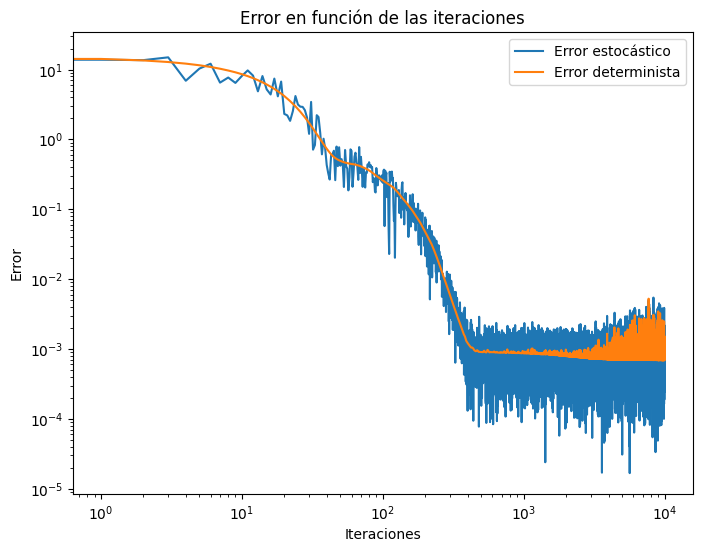

In [21]:
iters = list(range(len(params_opt)))

deterministic_error = [loss(param) for param in params_opt]
stochastic_error = [loss(param, batch_size=5) for param in params_opt]

plt.figure(figsize=(8, 6))
plt.plot(iters, stochastic_error, label="Error estocástico")
plt.plot(iters, deterministic_error, label="Error determinista")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Error en función de las iteraciones")
plt.legend()
plt.show()

Este gráfico permite ver una correlación entre el error determinista y el error estocástico: la virtud de la optimización mediante mini batches.

A continuación, graficamos el resultado de la red neuronal entrenada.

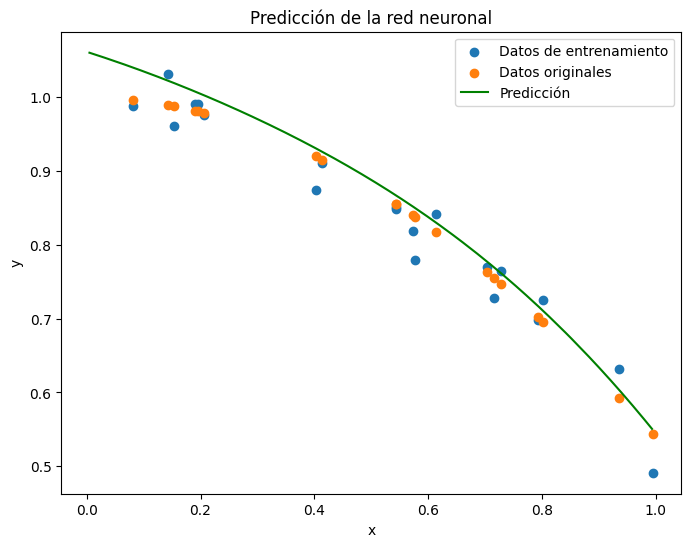

In [22]:
x_test = np.random.random((xdim, 300))

sorted_indices = np.argsort(x_test.flatten())
x_test = x_test.flatten()[sorted_indices]


y = net(params_opt[-1], x_test)


plt.figure(figsize=(8, 6))

plt.scatter(x_train.flatten(), y_train.flatten(), label="Datos de entrenamiento")

plt.scatter(x_train.flatten(), f_true(x_train).flatten(), label="Datos originales")

plt.plot(x_test.flatten(), y.flatten(), color="green", label="Predicción")

plt.xlabel("x")

plt.ylabel("y")

plt.title("Predicción de la red neuronal")

plt.legend()

plt.show()

Terminamos esta sección generando una animación del entrenamiento de la red y comentando los resultados.

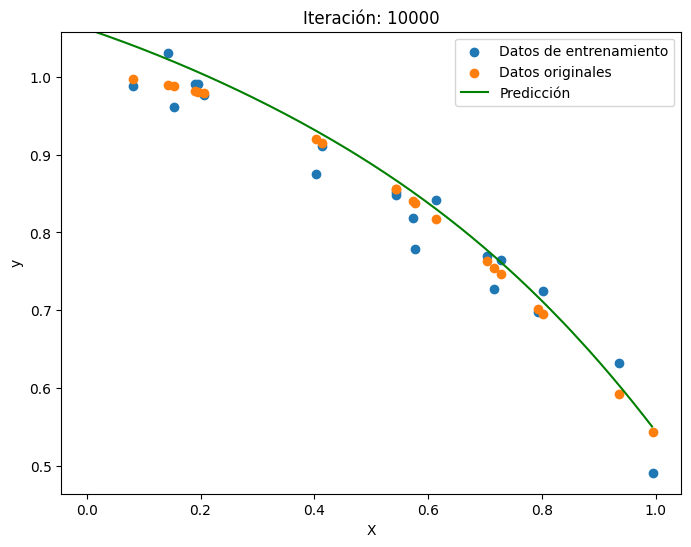

In [23]:
# Definir el área de dibujo
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("X")
ax.set_ylabel("y")

scatter_train = ax.scatter(
    x_train.flatten(), y_train.flatten(), label="Datos de entrenamiento"
)
scatter_original = ax.scatter(
    x_train.flatten(), f_true(x_train).flatten(), label="Datos originales"
)
(plot_pred,) = ax.plot(
    x_test.flatten(),
    np.zeros_like(x_test).flatten() + 0.5,
    color="green",
    label="Predicción",
)

ax.legend()  # Agregar una leyenda para diferenciar los gráficos


# Función para actualizar el gráfico
def actualizar_grafico(frame, to_be_plotted, linea):
    iteracion, valores = to_be_plotted[frame]
    linea.set_ydata(valores.flatten())  # Actualizar los datos
    ax.set_title(f"Iteración: {iteracion}")
    return (linea,)


to_be_plotted = [
    (iter, net(params, x_test))
    for iter, params in enumerate(params_opt)
    if iter % 10 == 0
]

# Crear la animación
ani = animation.FuncAnimation(
    fig,
    actualizar_grafico,
    frames=len(to_be_plotted),  # Número de fotogramas
    fargs=(to_be_plotted, plot_pred),  # Argumentos para la función de actualización
    blit=True,
    repeat=False,
)

# Guardar la animación como un video MP4
if not os.path.exists("movies"):
    os.makedirs("movies")
nombre_video = "./movies/P1.mp4"
ani.save(nombre_video, writer="ffmpeg", fps=24)

# Mostrar el video en el notebook
display(Video(nombre_video))

Se puede ver como la red neuronal se ajusta a los datos originales pese a haber sido entrenada con ruido. En la jerga del aprendizaje de máquinas, no hay *overfitting* de la red neuronal al ruido, más bien es capáz de generalizar de manera correcta.

### **Ejercicio 2: Aproximación de esperanzas condicionales vía redes neuronales**

Sean $X$, $Y$ variables aleatorias y $f$ una función continua, luego es sabido de clases que el problema de encontrar una función que minimice el error cuadrático medio

$$  \min_{f} \mathbb{E} [(Y - f(X))^2] $$

Viene dado por

$$ f(x) = \mathbb{E} [Y \, | \, X = x] $$

El objetivo de este ejercicio es ver numéricamente como una red neuronal entrenada para minimizar el error cuadrático medio de una muestra de puntos $\{x_i, y_i \}$ tales que $f(x_i ) = y_i$, con $f$ desconocida, en realidad se aproxima a la esperanza condicional con $X$ e $Y$ tales que $x_i \sim X$, $y_i \sim Y$.

Para este ejercicio consideremos $X$ con ley $\text{Unif}(-1,1)$, la función que buscamos aproximar será

$$ f(x) = e^{-2 x^2}$$

Y la ley de $Y$ supongamos que es $f(X) \, + \, \text{N}(0, 0.1^2)$.

#### **Ejercicio 2.1: Generar datos de entrenamiento**

Samplee 100 puntos de la ley de $X$ dada antes y con ello obtenga 100 muestras aleatorias correspondientes de $Y$.

##### **Solución Ejercicio 2.1.**

Obtenemos el sample especificado.

In [34]:
N_samples = 100
std = 0.1

# Sampleo de puntos aleatorios entre -1 y 1:
x = np.random.uniform(-1, 1, N_samples)

# Evaluando en Y para obtener las muestras correspondientes:
y = np.exp(-2 * x**2) + np.random.normal(0, std, N_samples)

Graficamos los resultados del sample.

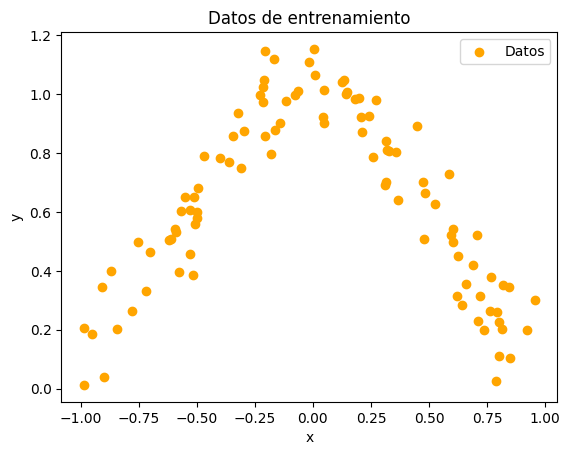

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, label="Datos", color="orange")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Datos de entrenamiento")
plt.show()

#### **Ejercicio 2.2: Cálculo de la esperanza condicional vía Montecarlo**

En este caso como es sabida la ley de $Y$ vía la función $f$ (en la realidad todo esto es desconocido) se puede calcular la esperanza condicional vía método de Montecarlo. Cree una función en Python que dado un $x \in [-1, 1]$ y una cantidad de muestras para la aproximación de Montecarlo, digamos $M$, calcule

$$ \mathbb{E} [Y \, | \, X = x] \approx \hat f(x) = \frac{1}{M} \sum_{j=1}^M f(x) + w_j $$

Donde los $w_j$ vienen sampleados desde una $\text{N}(0, 0.1^2)$. Realice 3 gráficos de $\hat f$ en $[-1, 1]$ uno utilizando $M=10$, $M=100$, $M=1000$ ¿qué observa cuando $M$ aumenta?

##### **Solución Ejercicio 2.2.**

Modelamos la función $\hat f$ como una función `montecarlo` que toma un conjunto de valores para $x$ y un valor para la cantidad de datos $M$ y entregue la aproximación mediante la formula presente en el enunciado para cada uno de los valores de $x$ (guardados en un `np.array`).

In [36]:
def montecarlo(x: np.array, n_samples: int) -> np.array:
    """
    Función que toma un np.array de puntos x y un entero n_samples, y retorna un np.array de len(x)
    elementos con la el valor aproximado de E[Y|X=x] mediante el método de Monte Carlo con n_samples.

    Args:
        x (np.array): Puntos x.
        n_samples (int): Número de muestras.

    Returns:
        np.array: Valores aproximados de E[Y|X=x].

    Raises:
        AssertionError: Si x no es un np.array.
        AssertionError: Si n_samples no es un entero.
    """
    assert isinstance(x, np.ndarray), "x debe ser un np.array."
    assert isinstance(n_samples, int), "n_samples debe ser un entero."


    x_len = len(x)
    f = lambda x: np.exp(-2 * x**2)
    w = np.random.normal(0, std, (n_samples, x_len))
    y = f(x) + np.mean(w, axis=0) # Aquí se sacó f(x) de la suma en la aproximación de E[Y|X=x] presente en el enunciado.

    return y

Graficamos `montecarlo` para los distintos valores de $N$ en $\{10,100,1000\}$.

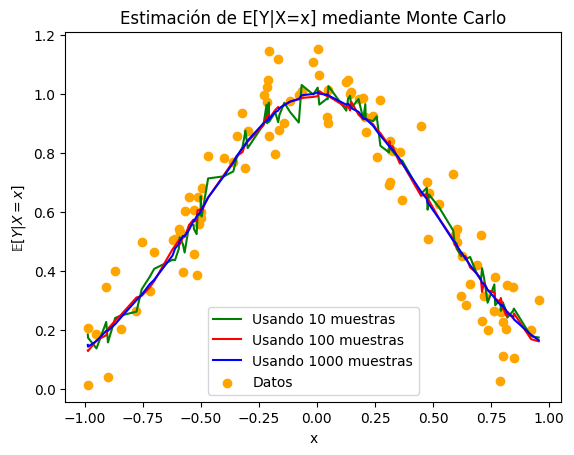

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
sorted_x = np.sort(x)

colores = ["blue", "red", "green"]
for n_samples in [10, 100, 1000]:
    ax.plot(
        sorted_x,
        montecarlo(sorted_x, n_samples),
        label=f"Usando {n_samples} muestras",
        color=colores.pop(),
    )

ax.scatter(x, y, label="Datos", color="orange")
ax.set_xlabel("x")
ax.set_ylabel(r"$\mathrm{\mathbb{E}}[Y | X=x]$")
ax.legend()
ax.set_title("Estimación de E[Y|X=x] mediante Monte Carlo")
plt.show()

#### Observación:
Debido a hacer un promedio de $M$ realilzaciones de $w_i \approx \text{N}(0,0.1^2)$, se puede apreciar que la varianza de $\hat f (x)$ disminuye a medida que $M$ aumenta, yendo como $M^{-1}\sigma^2$. Luego, observamos que las desviaciones $|\hat f - f|$ disminuyen a medida que $M$ aumenta (pues la magnitud de las desviaciones sólo depende de la varianza, al ser los $w_i$ sampleados de una normal centrada en 0).

#### **Ejercicio 2.3: Observando la aproximación de una red neuronal**

Entrene una red neuronal de una sola capa oculta con pérdida cuadrática para que ajuste a los datos que usted generó en el ejercicio 2.1, puede utilizar la función de pérdida y el ancho que más le acomode (o que mejores resultados le entregue). Grafique la predicción de la red neuronal en $[-1, 1]$ y compare con el resultado del ejercicio 2.2.

*Indicación: Puede utilizar el código creado en el ejercicio 1, o bien, utilizar alguna librería como Pytorch, Tensorflow, etc.*

##### **Solución Ejercicio 2.3.**

Haremos uso de `PyTorch` para resolver este ejercicio.

Como es de costumbre con `torch`, comenzamos definiendo una clase para redes neuronales.

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(
        self, dim_input, dim_output, n_layers, layer_width, activation, **layer_kwargs
    ) -> None:
        super().__init__()
        # Se crean las capas internas
        if n_layers == 0:
            raise ValueError(
                "n_layers debe ser mayor a 0 (o sino sería una red sin llamadas a la función de activación)"
            )
        if type(layer_width) == list:

            assert (
                len(layer_width) == n_layers
            ), "El largo de layer_width, como lista, debe ser igual a n_layers"
            self.first_layer = nn.Linear(dim_input, layer_width[0], **layer_kwargs)
            self.inner_layers = nn.ModuleList(
                [
                    nn.Linear(layer_width[n], layer_width[n + 1], **layer_kwargs)
                    for n in range(n_layers - 1)
                ]
            )
            self.last_layer = nn.Linear(layer_width[-1], dim_output, **layer_kwargs)
        else:
            self.first_layer = nn.Linear(dim_input, layer_width, **layer_kwargs)
            self.inner_layers = nn.ModuleList(
                [
                    nn.Linear(layer_width, layer_width, **layer_kwargs)
                    for n in range(n_layers - 1)
                ]
            )
            self.last_layer = nn.Linear(layer_width, dim_output, **layer_kwargs)
        self.activation = activation

    # Función de forward, que dado un input calcula el output de la red
    def forward(self, input):
        input = self.activation(self.first_layer(input))
        for layer in self.inner_layers:
            input = self.activation(layer(input))  # Efecto de activación

        return self.last_layer(input)

Continuamos ahora con la definición de la función de pérdida `loss_func`.

In [53]:
def loss_func(network_output, data):
    """
    Función de pérdida cuadrática media (MSE).

    Args:
        network_output (torch.Tensor): La salida de la red neuronal.
        data (torch.Tensor): Los datos de salida reales.

    Returns:
        torch.Tensor: El valor de la pérdida cuadrática media.

    Raises:
        AssertionError: Si network_output no es un torch.Tensor.
        AssertionError: Si data no es un torch.Tensor.
        AssertionError: Si las dimensiones de network_output y data no son iguales.
    """
    assert isinstance(
        network_output, torch.Tensor
    ), "network_output debe ser un torch.Tensor."
    assert isinstance(data, torch.Tensor), "data debe ser un torch.Tensor."
    assert (
        network_output.shape == data.shape
    ), "Las dimensiones de network_output y data deben ser iguales."

    # Pérdida cuadrática media
    loss = F.mse_loss(network_output, data)

    return loss

Definimos la función `closure` que se utilizará posteriormente para el optimizador.

In [54]:
def closure():
    """
    Función de cierre utilizada en el optimizador.

    Esta función realiza los siguientes pasos:
    1. Pone a cero los gradientes del optimizador.
    2. Calcula la salida del modelo.
    3. Calcula la pérdida entre la salida del modelo y los datos reales.
    4. Realiza la diferenciación automática (backpropagation).

    Returns:
        torch.Tensor: El valor de la pérdida.
    """
    
    optimizer.zero_grad()  # Se actualizan los pesos haciendo gradiente 0
    output = model(x_data)
    loss = loss_func(output, y_data)  # Se calcula la función de pérdida
    loss.backward()  # Diferenciación automática

    return loss

Definimos el modelo, el optimizador y aplicamos las iteraciones de ADAM.

In [89]:
# Definimos el modelo
model = NeuralNetwork(
    dim_input=1,
    dim_output=1,
    n_layers=1,
    layer_width=100,
    activation=F.tanh,
    dtype=torch.double,
)
optimizer = optim.Adam(model.parameters())

# Pasamos los datos a formato de torch
x_data = torch.tensor(x, dtype=torch.double).unsqueeze(1)
y_data = torch.tensor(y, dtype=torch.double).unsqueeze(1)

# Entrenamiento
n_iters = 5000
loss_record = []

for i in tqdm(range(n_iters)) if tqdm_is_available else range(n_iters):
    loss_record.append(
        loss_func(model(x_data), y_data).item()
    )  # Esto en verdad no es eficiente, pues loss ya está siendo calculada en closure.
    optimizer.step(closure)
    
    # Pausamos el entrenamiento con una KeyboardInterrupt
    try:
        pass
    except KeyboardInterrupt:
        break

100%|██████████| 5000/5000 [00:02<00:00, 2347.29it/s]


Graficamos la función de perdida a lo largo del entrenamiento.

Text(0, 0.5, 'Pérdida')

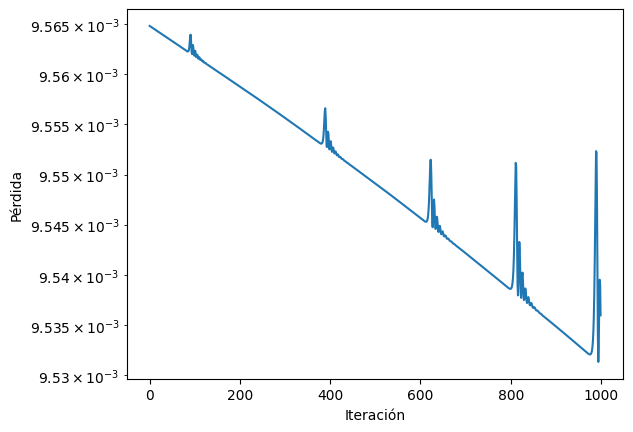

In [100]:
# Graficamos la pérdida
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_record[6000:7000])
ax.set_yscale("log")
ax.set_xlabel("Iteración")
ax.set_ylabel("Pérdida")

Graficamos la predicción de la red neuronal resultante.

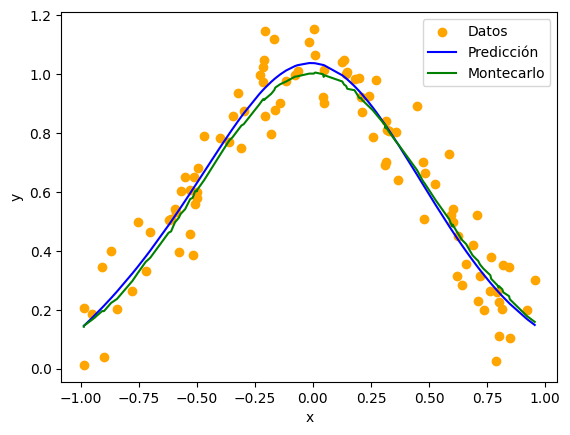

In [91]:
# Graficamos el resultado:
x_test = np.linspace(-1, 1, 600)
x_sorted = np.sort(x_test)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, label="Datos", color="orange")
ax.plot(
    sorted_x,
    model(torch.tensor(sorted_x).unsqueeze(1)).detach().numpy(),
    label="Predicción",
    color="blue",
)
ax.plot(sorted_x, montecarlo(sorted_x, 1000), label="Montecarlo", color="green")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

#### **Conclusión**

En la tarea de regresión, observamos que la red neuronal pareciera aproximarse a la esperanza condicional (que es al final, $f(x)$). Vemos que con 5000 iteraciones alcanza para que detalles como los puntos de inflexión en las colas de la función $f(x)$ sean capturados por la red neuronal. Sin embargo, algo interesante ocurre al seguir entrenando la red (o al agregar más capas ocultas).

***Extra: Observación de sobrefiteo***

Sigamos entrenando la red neuronal con 10000 iteraciones más.

In [92]:
# Entrenamiento extra
n_iters = 10000

for i in tqdm(range(n_iters)) if tqdm_is_available else range(n_iters):
    loss_record.append(
        loss_func(model(x_data), y_data).item()
    )  # Esto en verdad no es eficiente, pues loss ya está siendo calculada en closure.
    optimizer.step(closure)
    
    # Pausamos el entrenamiento con una KeyboardInterrupt
    try:
        pass
    except KeyboardInterrupt:
        break

100%|██████████| 10000/10000 [00:04<00:00, 2248.42it/s]


Vemos un comportamiento no suave de la función de pérdida:

Text(0, 0.5, 'Pérdida')

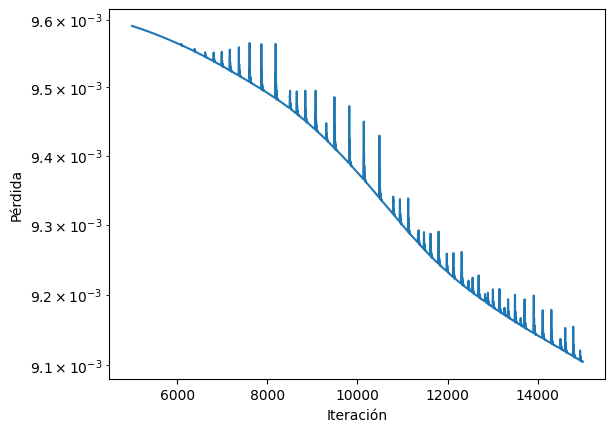

In [102]:
# Graficamos la nueva pérdida
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(5000, 15000), loss_record[5000:])
ax.set_yscale("log")
ax.set_xlabel("Iteración")
ax.set_ylabel("Pérdida")

Y la nueva predicción de la red neuronal queda:

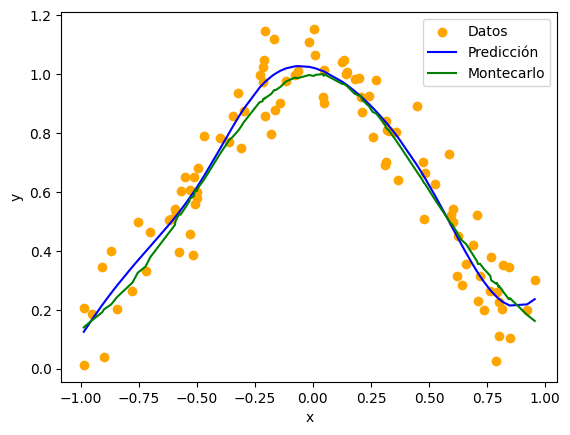

In [95]:
x_test = np.linspace(-1, 1, 600)
x_sorted = np.sort(x_test)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, label="Datos", color="orange")
ax.plot(
    sorted_x,
    model(torch.tensor(sorted_x).unsqueeze(1)).detach().numpy(),
    label="Predicción",
    color="blue",
)
ax.plot(sorted_x, montecarlo(sorted_x, 1000), label="Montecarlo", color="green")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

Hmmm. Repitamos este ciclo un poco más.

In [96]:
# Entrenamiento extra
n_iters = 50000

for i in tqdm(range(n_iters)) if tqdm_is_available else range(n_iters):
    # Ya no guardo la loss.
    optimizer.step(closure)
    # Pausamos el entrenamiento con una KeyboardInterrupt
    try:
        pass
    except KeyboardInterrupt:
        break

100%|██████████| 50000/50000 [00:15<00:00, 3159.07it/s]


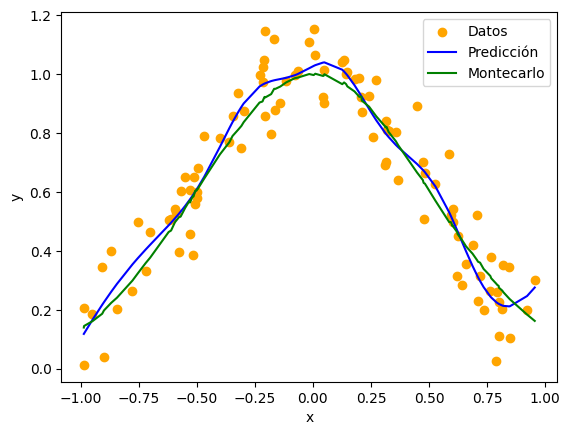

In [97]:
x_test = np.linspace(-1, 1, 600)
x_sorted = np.sort(x_test)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, label="Datos", color="orange")
ax.plot(
    sorted_x,
    model(torch.tensor(sorted_x).unsqueeze(1)).detach().numpy(),
    label="Predicción",
    color="blue",
)
ax.plot(sorted_x, montecarlo(sorted_x, 1000), label="Montecarlo", color="green")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

Pareciera que al seguir entrenando la red, en verdad estamos perdiendo la cualidad de aproximación de la esperanza condicional. Este es un fenómeno conocido como "overfitting", en el cual dado que la distribución para $Y$ tiene un ancho no nulo, es posible que una red neuronal, con sus amplias capacidades de ajuste, en verdad empiece a ajustarse al ruido, más que seguir la tendencia de la esperanza condicional. Es de esperar que con menos parámetros, el fenómeno de sobrefiteo sea menos pronunciado (igual 1000 neuronas son hartas neuronas).